In [1]:
import os, sys
import pandas as pd
import numpy as np
import re
import collections, itertools
from scipy.stats import gaussian_kde

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import seaborn as sns
plt.rcParams['figure.dpi'] = 300


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading in the ALFA VCF

In [3]:
alfa_id_to_pop = {
    'SAMN10492695': 'European',
    'SAMN10492698': 'African_American',
    'SAMN10492696': 'African_Others',
    'SAMN10492703': 'Total_African',
    'SAMN10492697': 'East_Asian',
    'SAMN10492702': 'South_Asian',
    'SAMN10492701': 'Other_Asian',
    'SAMN10492704': 'Total_Asian',
    'SAMN10492699': 'Latin_American_1',
    'SAMN10492700': 'Latin_American_2',
    'SAMN11605645': 'Other',
    'SAMN10492705': 'Total'
}

alfa_ids, pop_names = list(alfa_id_to_pop.keys()), list(alfa_id_to_pop.values())
pops = ['European', 'African_American', 'African_Others', 'East_Asian', 'South_Asian', 'Other_Asian', 'Latin_American_1', 'Latin_American_2', 'Other']
pops_af = [x+'_AF' for x in pops]

def read_alfa_vcf(path, split_info=True, deduplicate=True, multiallelic='merge'):
    
    # read vcf
    with open(path, 'r') as file:
        for idx,line in enumerate(file.readlines()):
            if line[:6]=='#CHROM': break
    vcf = pd.read_table(path, header=idx).rename(columns={'#CHROM': 'CHROM'})
    
    # split INFO fields into separate columns
    if split_info:
        info_cols = [f"INFO_{x}" for x in vcf.loc[0, 'INFO'].split('=')[0].split(':')]
        vcf[info_cols] = vcf['INFO'].str.split('=').str[1].str.split(':', expand=True)
        vcf = vcf.drop(columns=['INFO'])
    
    # de-duplicate rsIDs while concatenating INFO fields across rows
    # (this is done in case the same variant has different INFO field values)
    vcf = vcf.groupby('ID').agg({col: ((lambda x: '|'.join(x)) if col in info_cols else 'first') 
                                 for col in vcf.columns})
    
    # split genotype columns into popID_AN and popID_AC
    for alfa_id, pop_name in alfa_id_to_pop.items():
        vcf[[pop_name+'_AN', pop_name+'_AC']] = vcf[alfa_id].str.split(':', expand=True)
    vcf = vcf.drop(columns=alfa_ids)
    
    # deal with multiallelic variants by either merging them or splitting them
    # (splitting will generate duplicate rsID values)
    if multiallelic=='merge':
        for pop in pop_names:
            vcf[pop+'_AC'] = (vcf[pop+'_AC'].str.split(',')
                              .apply(lambda x: np.sum([int(x_) for x_ in x])))
    elif multiallelic=='split':
        cols_to_split = ['ALT'] + [x+'_AC' for x in pop_fields]
        vcf[cols_to_split] = vcf[cols_to_split].apply(lambda col: col.str.split(','), axis='rows')
        vcf = vcf.explode(cols_to_split)
        
    # adjust dtypes
    vcf = vcf.astype({
        'REF': 'category',
        'ALT': 'category',
        'QUAL': 'category',
        'FILTER': 'category',
        'FORMAT': 'category'} | {pop+"_AN":np.uint32 for pop in pop_names} | {pop+"_AC":np.uint32 for pop in pop_names})
    
    # calculate frequencies
    for pop in pop_names:
        vcf[pop+'_AF'] = vcf[pop+'_AC'] / vcf[pop+'_AN']

    return vcf
        


In [4]:
# df = read_alfa_vcf('data/ALFA_20200909020902_clinical.vcf')
# df.to_parquet('ALFA_20200909020902_clinical.parquet')
df = pd.read_parquet('ALFA_20200909020902_clinical.parquet')

In [5]:
df['INFO_clin_sig'].value_counts().head(40)

uncertain-significance                                                               116146
likely-benign                                                                         61299
benign                                                                                25926
pathogenic                                                                            18279
likely-benign|uncertain-significance                                                  10130
likely-benign|benign                                                                   9760
likely-pathogenic                                                                      6642
not-provided                                                                           3984
likely-pathogenic|pathogenic                                                           2214
benign|uncertain-significance                                                          2080
benign-likely-benign|likely-benign|benign                                       

In [6]:
df = df[~df['Total_AF'].isna()]

In [7]:
all_pop_cols = df.columns.str.contains('|'.join(pop_names))

In [8]:
df.loc[:, all_pop_cols] = df.loc[:, all_pop_cols].fillna(0)

### Looking at total allele frequencies

Calculating an average frequency across populations that assumes:
1. All populations are of the same size
2. All populations are equally distant from each other (e.g. $F_{ST}$-wise)

In [9]:
df['Average_AF'] = df[pops_af].mean(1)

In [61]:
np.linalg.lstsq(df[['Total_AN']].values, df[['European_AN']].values, rcond=None)

(array([[0.84414556]]), array([2.85921086e+12]), 1, array([37608816.32866397]))

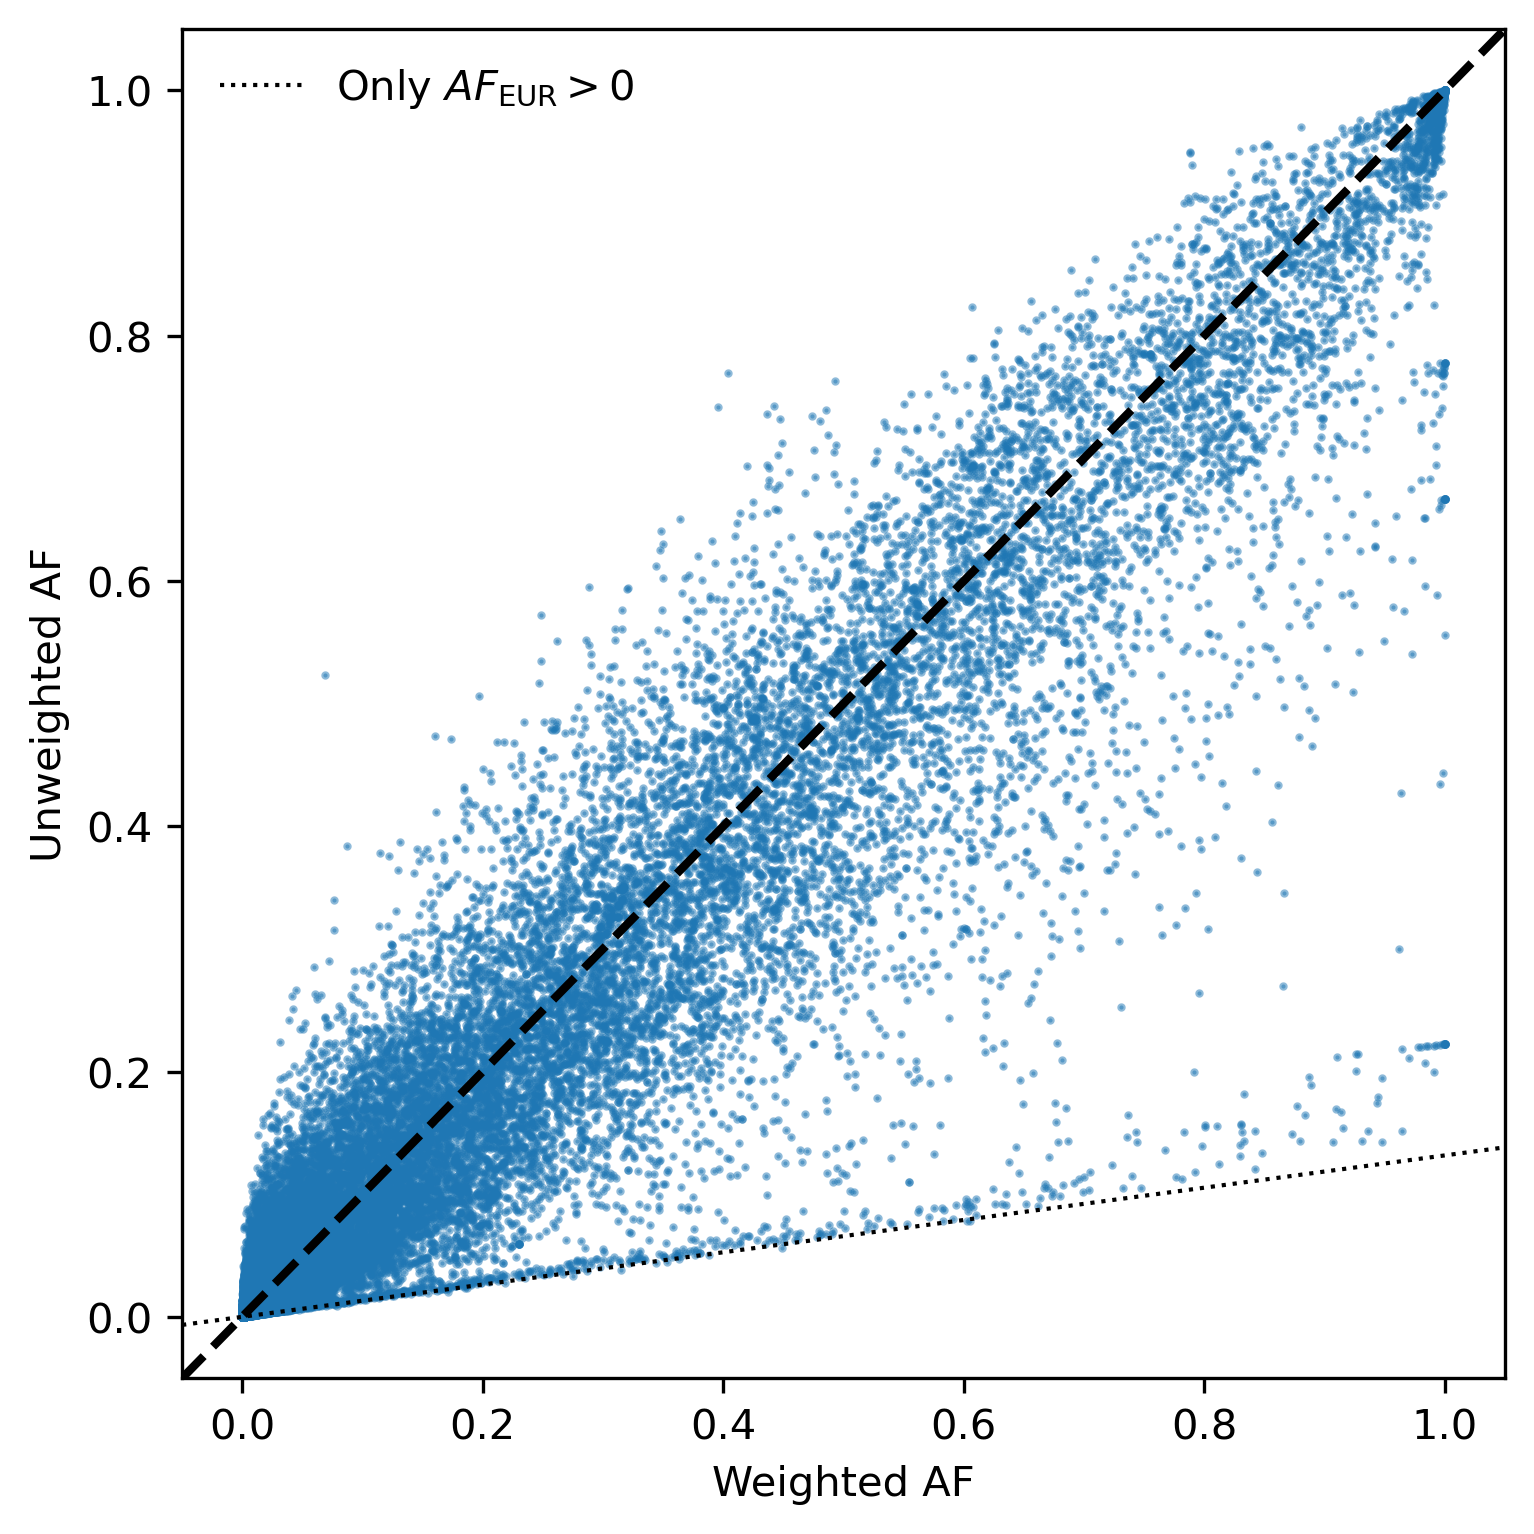

In [67]:
fig, ax = plt.subplots(1,1,figsize=(5,5), constrained_layout=True)

ax.scatter(df['Total_AF'], df['Average_AF'], alpha=0.5, s=1)
ax.axline((0,0), slope=1, lw=2, ls='dashed', color='k')
ax.axline((0,0), slope=1/9/0.8441, lw=1, ls='dotted', color='k', label=r"Only $AF_{\mathrm{EUR}}>0$")
ax.set_xlabel('Weighted AF')
ax.set_ylabel('Unweighted AF')
ax.legend(frameon=False);

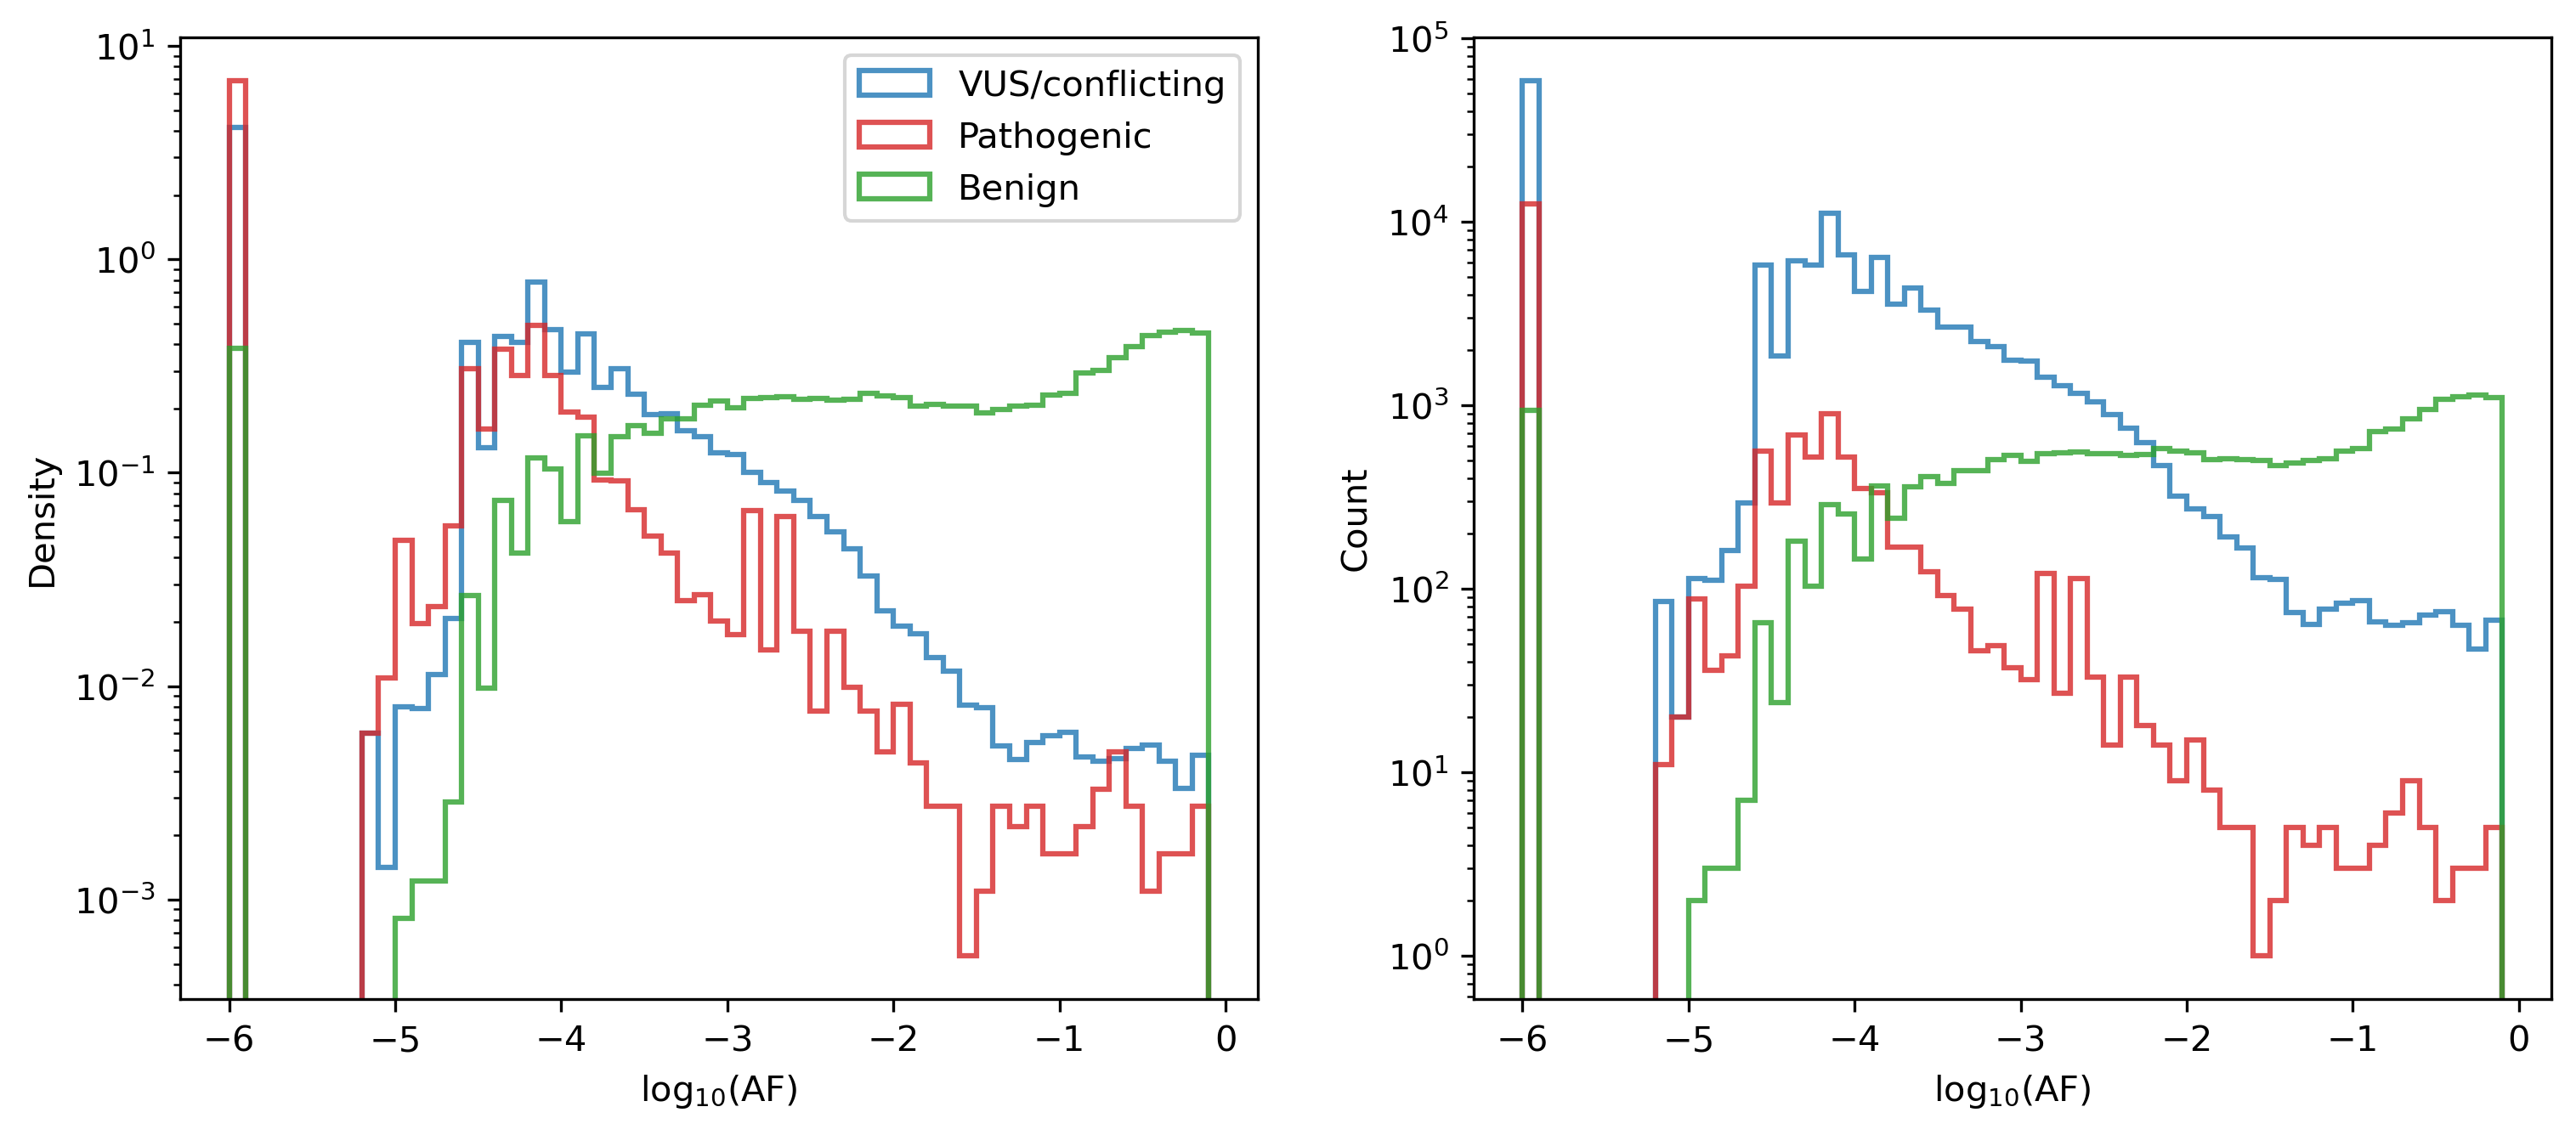

In [22]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

bins = np.arange(-6, 0, 0.1)
ax = axs[0]
ax.hist(
    np.log10(df[df['INFO_clin_sig'].str.contains('uncertain-significance|conflicting-interpretations-of-pathogenicity')]['Total_AF'] + 1e-6), 
    density=True, bins=bins, alpha=0.8, histtype='step', color='tab:blue', lw=1.5)
ax.hist(np.log10(df[df['INFO_clin_sig']=='pathogenic']['Total_AF'] + 1e-6), 
        density=True, bins=bins, alpha=0.8, histtype='step', color='tab:red', lw=1.5)
ax.hist(np.log10(df[df['INFO_clin_sig']=='benign']['Total_AF'] + 1e-6), 
        density=True, bins=bins, alpha=0.8, histtype='step', color='tab:green', lw=1.5)
ax.set_yscale('log');
ax.set_xlabel(r'$\log_{10}(\mathrm{AF})$')
ax.set_ylabel('Density')
ax.legend(['VUS/conflicting', 'Pathogenic', 'Benign'])

ax = axs[1]
ax.hist(
    np.log10(df[df['INFO_clin_sig'].str.contains('uncertain-significance|conflicting-interpretations-of-pathogenicity')]['Total_AF'] + 1e-6), 
    density=False, bins=bins, alpha=0.8, histtype='step', color='tab:blue', lw=1.5)
ax.hist(np.log10(df[df['INFO_clin_sig']=='pathogenic']['Total_AF'] + 1e-6), 
        density=False, bins=bins, alpha=0.8, histtype='step', color='tab:red', lw=1.5)
ax.hist(np.log10(df[df['INFO_clin_sig']=='benign']['Total_AF'] + 1e-6), 
        density=False, bins=bins, alpha=0.8, histtype='step', color='tab:green', lw=1.5)
ax.set_xlabel(r'$\log_{10}(\mathrm{AF})$')
ax.set_ylabel('Count')
ax.set_yscale('log');

### Joining with the ClinVar summary table

In [68]:
variants = pd.read_parquet('data/variant_summary_GRCh38.parquet')
variants['rsID'] = 'rs' + variants['RS# (dbSNP)'].astype(str)

### Looking at cross-population entropy

In [ ]:
df_nonzeroaf = df[((df['Total_AF']!=0) & (~df['Total_AF'].isna()))].copy()

### ClinVar variant summary table 

In [106]:
df_annot = df.merge(variants, left_index=True, right_on='rsID', how='inner')

In [123]:
variants_with_rsid = variants[variants['RS# (dbSNP)']!=-1]

In [130]:
variants['Type'].unique().tolist()

['Indel',
 'Deletion',
 'single nucleotide variant',
 'Duplication',
 'Microsatellite',
 'Insertion',
 'Translocation',
 'Inversion',
 'copy number gain',
 'Variation',
 'copy number loss',
 'Complex']

In [128]:
variants_with_rsid[variants_with_rsid.duplicated('RS# (dbSNP)', keep=False)].sort_values('PositionVCF')

,AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt,rsID
14763,23110,Microsatellite,NM_000332.4(ATXN1):c.589CAG[36_38] (p.Gln208[3...,6310,ATXN1,HGNC:10548,Pathogenic,1,2002-03-01,193922926,...,1,NaN,0,OMIM:601556.0001,1,8071,-1,na,na,rs193922926
5450,17992,Microsatellite,NM_000333.4:c.89ACG[7_17],6314,ATXN7,HGNC:10560,Benign,0,NaT,193922929,...,1,NaN,0,OMIM:607640.0001,1,2953,-1,na,na,rs193922929
45618,47513,Microsatellite,NM_001039958.1(MESP2):c.535GGGCAGGGGCAA[2_4],145873,MESP2,HGNC:29659,Benign,0,2013-01-17,397507446,...,1,NaN,0,None,1,38910,-1,na,na,rs397507446
6519,18590,Microsatellite,NM_004993.6(ATXN3):c.892CAG[8_36],4287,ATXN3,HGNC:7106,Pathogenic; risk factor,1,1994-11-01,193922928,...,1,NaN,0,OMIM:607047.0001,1,3551,-1,na,na,rs193922928
17926,24857,Microsatellite,NM_000044.6:c.171GCA[10_36],367,AR,HGNC:644,Pathogenic,1,2001-06-01,3032358,...,1,NaN,0,OMIM:313700.0014,1,9818,-1,na,na,rs3032358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758382,498585,single nucleotide variant,NM_001243133.2(NLRP3):c.2322-6A>G,114548,NLRP3,HGNC:16400,Likely benign,0,2022-08-22,778792605,...,2,NaN,0,ClinGen:CA658795660,2,514376,247434097,A,G,rs778792605
661753,448075,single nucleotide variant,NM_001243133.2(NLRP3):c.2343G>A (p.Ser781=),114548,NLRP3,HGNC:16400,Benign,0,2022-10-10,764753476,...,1,NaN,0,ClinGen:CA1495221,2,469050,247434124,G,A,rs764753476
1316663,799211,single nucleotide variant,NM_001243133.2(NLRP3):c.2343G>T (p.Ser781=),114548,NLRP3,HGNC:16400,Likely benign,0,2019-03-24,764753476,...,1,NaN,0,None,2,811932,247434124,G,T,rs764753476
792149,515845,single nucleotide variant,NM_001243133.2(NLRP3):c.2576A>C (p.Tyr859Ser),114548,NLRP3,HGNC:16400,Uncertain significance,0,2022-10-13,180177452,...,1,NaN,0,ClinGen:CA345562274,2,536882,247436053,A,C,rs180177452


In [127]:
df.loc['rs121918057']

CHROM                  NC_000001.11
POS                        45014803
ID                      rs121918057
REF                               G
ALT                             A,T
QUAL                              .
FILTER                            .
FORMAT                        AN:AC
INFO_clin_sig            pathogenic
European_AN                   32802
European_AC                       1
African_American_AN            3238
African_American_AC               0
African_Others_AN               114
African_Others_AC                 0
Total_African_AN               3352
Total_African_AC                  0
East_Asian_AN                   120
East_Asian_AC                     0
South_Asian_AN                  104
South_Asian_AC                    0
Other_Asian_AN                   26
Other_Asian_AC                    0
Total_Asian_AN                  146
Total_Asian_AC                    0
Latin_American_1_AN             500
Latin_American_1_AC               0
Latin_American_2_AN         

In [110]:
df_annot

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,INFO_clin_sig,European_AN,...,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt,rsID
42615,NC_000007.14,5973522,rs10000,A,G,.,.,AN:AC,benign,13442,...,15,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,ClinGen:CA011559,2,36690,5973522,A,G,rs10000
811399,NC_000010.11,86687214,rs1000020884,G,C,.,.,AN:AC,uncertain-significance,9690,...,2,NaN,0,ClinGen:CA211181343,2,532931,86687214,G,C,rs1000020884
120826,NC_000004.12,15480853,rs10000250,A,G,.,.,AN:AC,benign,22076,...,4,NaN,0,ClinGen:CA150860,2,126233,15480853,A,G,rs10000250
602067,NC_000011.10,108316037,rs1000032847,T,C,.,.,AN:AC,uncertain-significance,9690,...,4,NaN,0,ClinGen:CA16619208,2,421279,108316037,T,C,rs1000032847
769862,NC_000012.12,21852163,rs1000035870,G,A,.,.,AN:AC,likely-benign,26584,...,2,NaN,0,ClinGen:CA233599584,2,508497,21852163,G,A,rs1000035870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536751,NC_000018.10,31082946,rs999869714,G,T,.,.,AN:AC,uncertain-significance,7618,...,1,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,None,2,922046,31082946,G,C,rs999869714
532330,NC_000005.10,112840106,rs999881274,C,G,.,.,AN:AC,likely-benign,9690,...,6,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,ClinGen:CA16604668,2,381895,112840106,C,G,rs999881274
381073,NC_000002.12,208325908,rs999890,T,G,.,.,AN:AC,benign,300168,...,2,NaN,0,"ClinGen:CA2079986,UniProtKB:Q9Y2I7#VAR_057098",2,333911,208325908,T,G,rs999890
379737,NC_000002.12,208325925,rs999891,A,G,.,.,AN:AC,benign,151576,...,2,NaN,0,ClinGen:CA2079991,2,333912,208325925,A,G,rs999891


In [115]:
df_annot[df_annot['rsID'].duplicated(False)]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,INFO_clin_sig,European_AN,...,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt,rsID
673386,NC_000005.10,112707548,rs1000470082,G,"A,C",.,.,AN:AC,uncertain-significance,9690,...,1,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,ClinGen:CA124924875,2,469850,112707548,G,C,rs1000470082
1681465,NC_000005.10,112707548,rs1000470082,G,"A,C",.,.,AN:AC,uncertain-significance,9690,...,1,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,None,2,1007704,112707548,G,T,rs1000470082
681817,NC_000009.12,127501038,rs1000632610,C,T,.,.,AN:AC,likely-benign,9690,...,3,NaN,0,ClinGen:CA199852960,2,472797,127501038,C,T,rs1000632610
766106,NC_000009.12,127501038,rs1000632610,C,T,.,.,AN:AC,likely-benign,9690,...,3,NaN,0,ClinGen:CA467236632,2,518042,127501038,C,G,rs1000632610
588472,NC_000016.10,68828240,rs1001200905,C,T,.,.,AN:AC,uncertain-significance,7618,...,4,NaN,0,ClinGen:CA16614994,2,406661,68828240,C,T,rs1001200905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406403,NC_000019.10,4101042,rs999810842,C,"G,T",.,.,AN:AC,uncertain-significance,9690,...,1,NaN,0,None,2,843844,4101042,C,G,rs999810842
672938,NC_000004.12,145655252,rs999844958,C,T,.,.,AN:AC,pathogenic|uncertain-significance,26588,...,5,NaN,0,ClinGen:CA107683237,2,466216,145655252,C,T,rs999844958
845231,NC_000004.12,145655252,rs999844958,C,T,.,.,AN:AC,pathogenic|uncertain-significance,26588,...,1,NaN,0,None,2,556925,145655252,C,G,rs999844958
591147,NC_000018.10,31082946,rs999869714,G,T,.,.,AN:AC,uncertain-significance,7618,...,5,"ACMG2013,ACMG2016,ACMG2021,ACMG2022",0,ClinGen:CA16615763,2,410653,31082946,G,T,rs999869714


In [109]:
df_annot['rsID'].isna()

42615      False
811399     False
120826     False
602067     False
769862     False
           ...  
1536751    False
532330     False
381073     False
379737     False
614211     False
Name: rsID, Length: 305766, dtype: bool

In [88]:
variants[variants['RS# (dbSNP)']!=-1]

,AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,NaT,397704705,...,"criteria provided, single submitter",2,NaN,0,"ClinGen:CA215070,OMIM:613653.0001",3,2,4781213,GGAT,TGCTGTAAACTGTAACTGTAAA
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,2010-06-29,397704709,...,no assertion criteria provided,1,NaN,0,"ClinGen:CA215072,OMIM:613653.0002",1,3,4787729,GCTGCTGGACCTGCC,G
5,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,2015-06-29,150829393,...,no assertion criteria provided,1,NaN,0,"OMIM:613624.0001,ClinGen:CA210674,UniProtKB:Q9...",1,4,84799209,G,A
7,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),55572,FOXRED1,HGNC:26927,Pathogenic,1,2022-06-28,267606829,...,"criteria provided, multiple submitters, no con...",5,NaN,0,"ClinGen:CA113792,OMIM:613622.0001",3,5,126275389,C,T
9,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),55572,FOXRED1,HGNC:26927,Pathogenic,1,2010-10-01,267606830,...,no assertion criteria provided,1,NaN,0,"ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O...",1,6,126277517,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324124,2403228,Indel,NM_006005.3(WFS1):c.*683delinsTGTGGGGGA,7466,WFS1,HGNC:12762,Uncertain significance,0,NaT,886059540,...,"criteria provided, single submitter",1,NaN,0,None,2,2429730,6303151,C,TGTGGGGGA
4324126,2403229,single nucleotide variant,NM_006005.3(WFS1):c.*553G>C,7466,WFS1,HGNC:12762,Benign,0,NaT,904935032,...,"criteria provided, single submitter",1,NaN,0,None,2,2429731,6303021,G,C
4324140,2403237,single nucleotide variant,NM_006005.3(WFS1):c.2030C>G (p.Ala677Gly),7466,WFS1,HGNC:12762,Uncertain risk allele,0,NaT,1730936563,...,"criteria provided, single submitter",1,NaN,0,None,2,2429739,6301825,C,G
4324142,2403242,single nucleotide variant,NM_006005.3(WFS1):c.1836G>C (p.Trp612Cys),7466,WFS1,HGNC:12762,Uncertain risk allele,0,NaT,775158434,...,"criteria provided, single submitter",1,NaN,0,None,2,2429740,6301631,G,C


Function to read the NCBI ALFA VCF files. 

TODO:
- Create chromosome number column from CHROM
- Optimize memory usage

In [55]:

df

In [83]:
df[df['INFO_clin_sig']=='pathogenic'].sort_values('Total_AF', ascending=False)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,INFO_clin_sig,European_AN,...,African_Others_AF,Total_African_AF,East_Asian_AF,South_Asian_AF,Other_Asian_AF,Total_Asian_AF,Latin_American_1_AF,Latin_American_2_AF,Other_AF,Total_AF
ID,,,,,,,,,,,,,,,,,,,,,
rs587779540,NC_000002.12,189006418,rs587779540,G,A,.,.,AN:AC,pathogenic,78,...,NaN,1.000000,1.000000,1.000000,NaN,1.000000,NaN,NaN,1.000000,1.000000
rs267606893,NC_012920.1,12706,rs267606893,T,C,.,.,AN:AC,pathogenic,646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.910180
rs3735819,NC_000008.11,11748803,rs3735819,T,C,.,.,AN:AC,pathogenic,24870,...,0.919355,0.899687,0.977612,0.858333,1.000000,0.981481,0.791667,0.840000,0.737748,0.751510
rs10800597,NC_000001.11,198898955,rs10800597,G,A,.,.,AN:AC,pathogenic,14286,...,0.912281,0.810930,0.825581,0.897959,0.923077,0.848214,0.753425,0.765574,0.723988,0.695077
rs60639710,NC_000001.11,198898549,rs60639710,G,T,.,.,AN:AC,pathogenic,14286,...,0.903509,0.808554,0.825581,0.897959,0.923077,0.848214,0.753425,0.765574,0.723988,0.694918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs1555536446,NC_000016.10,89745062,rs1555536446,GCCA,G,.,.,AN:AC,pathogenic,6962,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rs1555546096,NC_000017.11,4898838,rs1555546096,C,T,.,.,AN:AC,pathogenic,6962,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rs1555546315,NC_000017.11,4899318,rs1555546315,AGGCGGCCCGGGGGGCCTCGGGC,A,.,.,AN:AC,pathogenic,6962,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
from scipy.stats import entropy

In [159]:
alfa_id_to_pop

{'SAMN10492695': 'European',
 'SAMN10492698': 'African_American',
 'SAMN10492696': 'African_Others',
 'SAMN10492703': 'Total_African',
 'SAMN10492697': 'East_Asian',
 'SAMN10492702': 'South_Asian',
 'SAMN10492701': 'Other_Asian',
 'SAMN10492704': 'Total_Asian',
 'SAMN10492699': 'Latin_American_1',
 'SAMN10492700': 'Latin_American_2',
 'SAMN11605645': 'Other',
 'SAMN10492705': 'Total'}

In [13]:
pops = ['European_AF', 'African_American_AF', 'African_Others_AF', 'East_Asian_AF', 'South_Asian_AF', 'Other_Asian_AF', 'Latin_American_1_AF', 'Latin_American_2_AF', 'Other_AF']

In [52]:
afs = df_nonzeroaf.loc[:, pops].fillna(0).values

In [15]:
afs_norm = afs / afs.sum(1, keepdims=True)

In [16]:
H = entropy(afs_norm, base=9, axis=1)

In [17]:
total_af = df_nonzeroaf['Total_AF'].values

In [18]:
x,y  = (total_af), (H)

In [39]:
X = np.log10(np.vstack((total_af_nz,H_nz)))
kernel = gaussian_kde((X))

In [40]:
densities = kernel(X)

In [35]:
H_nz = H[H>0]
total_af_nz = total_af[H>0]

In [31]:
afs_norm[np.logical_and(H<0.9, H>0.8, total_af>0.95)].shape

(4555, 9)

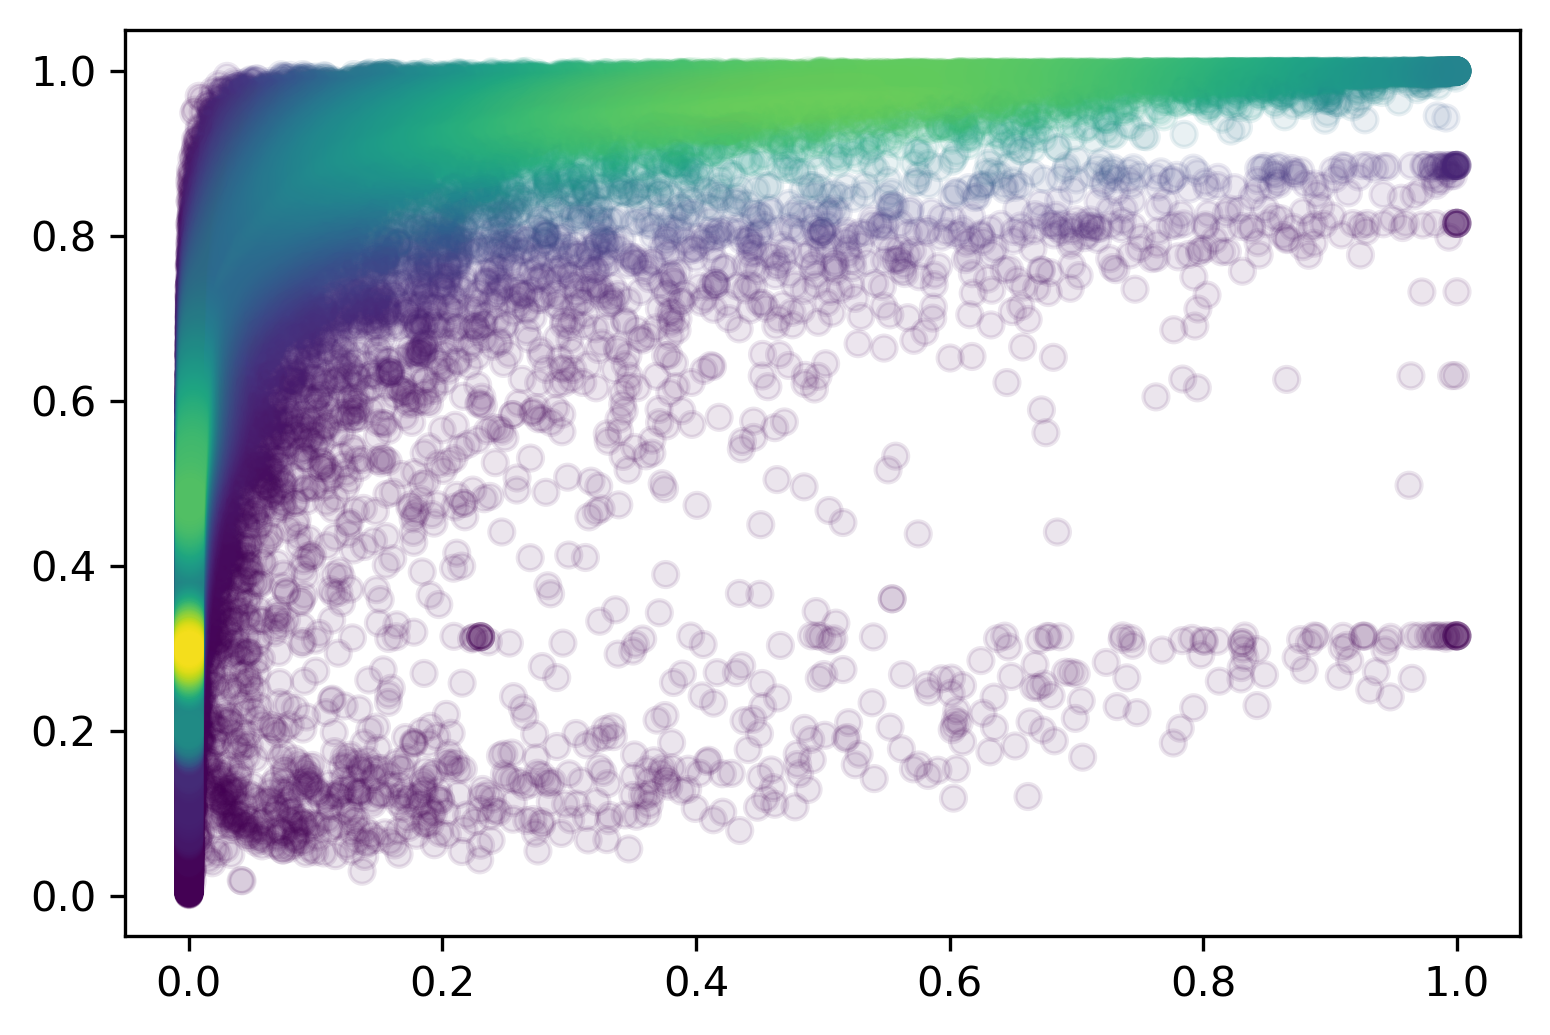

In [ ]:
idx = densities.argsort()
plt.scatter(total_af_nz[idx], H_nz[idx], alpha=0.1, c=densities[idx], edgecolor=None)
# plt.yscale('log')
# plt.xscale('log')

In [ ]:
idx = densities.argsort()
plt.scatter(total_af_nz[idx], H_nz[idx], alpha=0.1, c=densities[idx], edgecolor=None)
# plt.yscale('log')
# plt.xscale('log')

In [67]:
df_nonzeroaf

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,INFO_clin_sig,European_AN,...,Total_African_AF,East_Asian_AF,South_Asian_AF,Other_Asian_AF,Total_Asian_AF,Latin_American_1_AF,Latin_American_2_AF,Other_AF,Total_AF,H
ID,,,,,,,,,,,,,,,,,,,,,
rs10000,NC_000007.14,5973522,rs10000,A,G,.,.,AN:AC,benign,13442,...,0.082989,0.027778,0.085106,0.018519,0.024691,0.136986,0.062295,0.108466,0.110417,0.937762
rs10000250,NC_000004.12,15480853,rs10000250,A,G,.,.,AN:AC,benign,22076,...,0.817662,0.967213,0.806122,0.982759,0.972222,0.892857,0.850746,0.861431,0.862393,0.999045
rs1000032847,NC_000011.10,108316037,rs1000032847,T,C,.,.,AN:AC,uncertain-significance,9690,...,0.000345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000071,0.000000
rs1000035870,NC_000012.12,21852163,rs1000035870,G,A,.,.,AN:AC,likely-benign,26584,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000056,0.000000
rs10001,NC_000019.10,7646335,rs10001,T,C,.,.,AN:AC,benign,41732,...,0.481180,0.741071,0.367347,0.821429,0.767857,0.414000,0.453822,0.378630,0.376478,0.979559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9998044,NC_000004.12,25121722,rs9998044,T,C,.,.,AN:AC,likely-benign,114868,...,0.052124,0.000000,0.000000,0.000000,0.000000,0.016224,0.006335,0.007850,0.003520,0.590370
rs999844958,NC_000004.12,145655252,rs999844958,C,T,.,.,AN:AC,pathogenic|uncertain-significance,26588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000085,0.000000
rs9998519,NC_000004.12,6291182,rs9998519,C,T,.,.,AN:AC,benign,20398,...,0.619217,0.919643,0.734694,0.892857,0.910714,0.616438,0.726230,0.643894,0.622225,0.994790


In [56]:
df_nonzeroaf['H'] = H

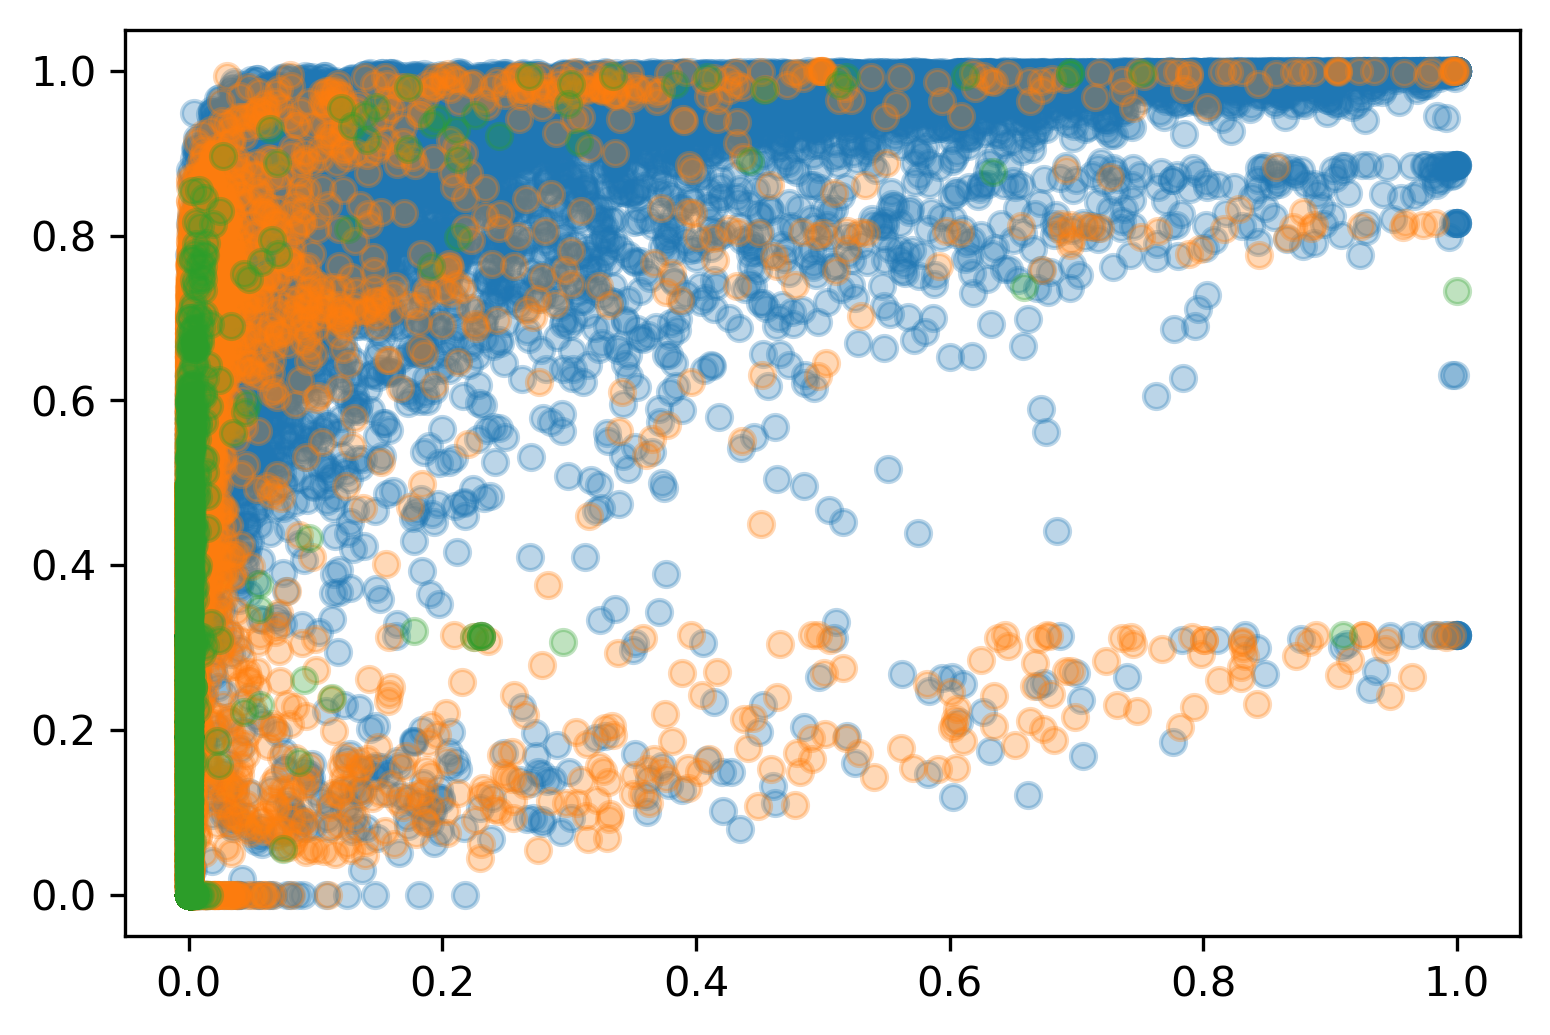

In [75]:
plt.scatter(df_nonzeroaf[df_nonzeroaf['INFO_clin_sig']=='benign']['Total_AF'], df_nonzeroaf[df_nonzeroaf['INFO_clin_sig']=='benign']['H'], alpha=0.3)
plt.scatter(df_nonzeroaf[df_nonzeroaf['INFO_clin_sig'].str.contains('uncertain-significance')]['Total_AF'], df_nonzeroaf[df_nonzeroaf['INFO_clin_sig'].str.contains('uncertain-significance')]['H'], alpha=0.3)
plt.scatter(df_nonzeroaf[df_nonzeroaf['INFO_clin_sig']=='pathogenic']['Total_AF'], df_nonzeroaf[df_nonzeroaf['INFO_clin_sig']=='pathogenic']['H'], alpha=0.3)


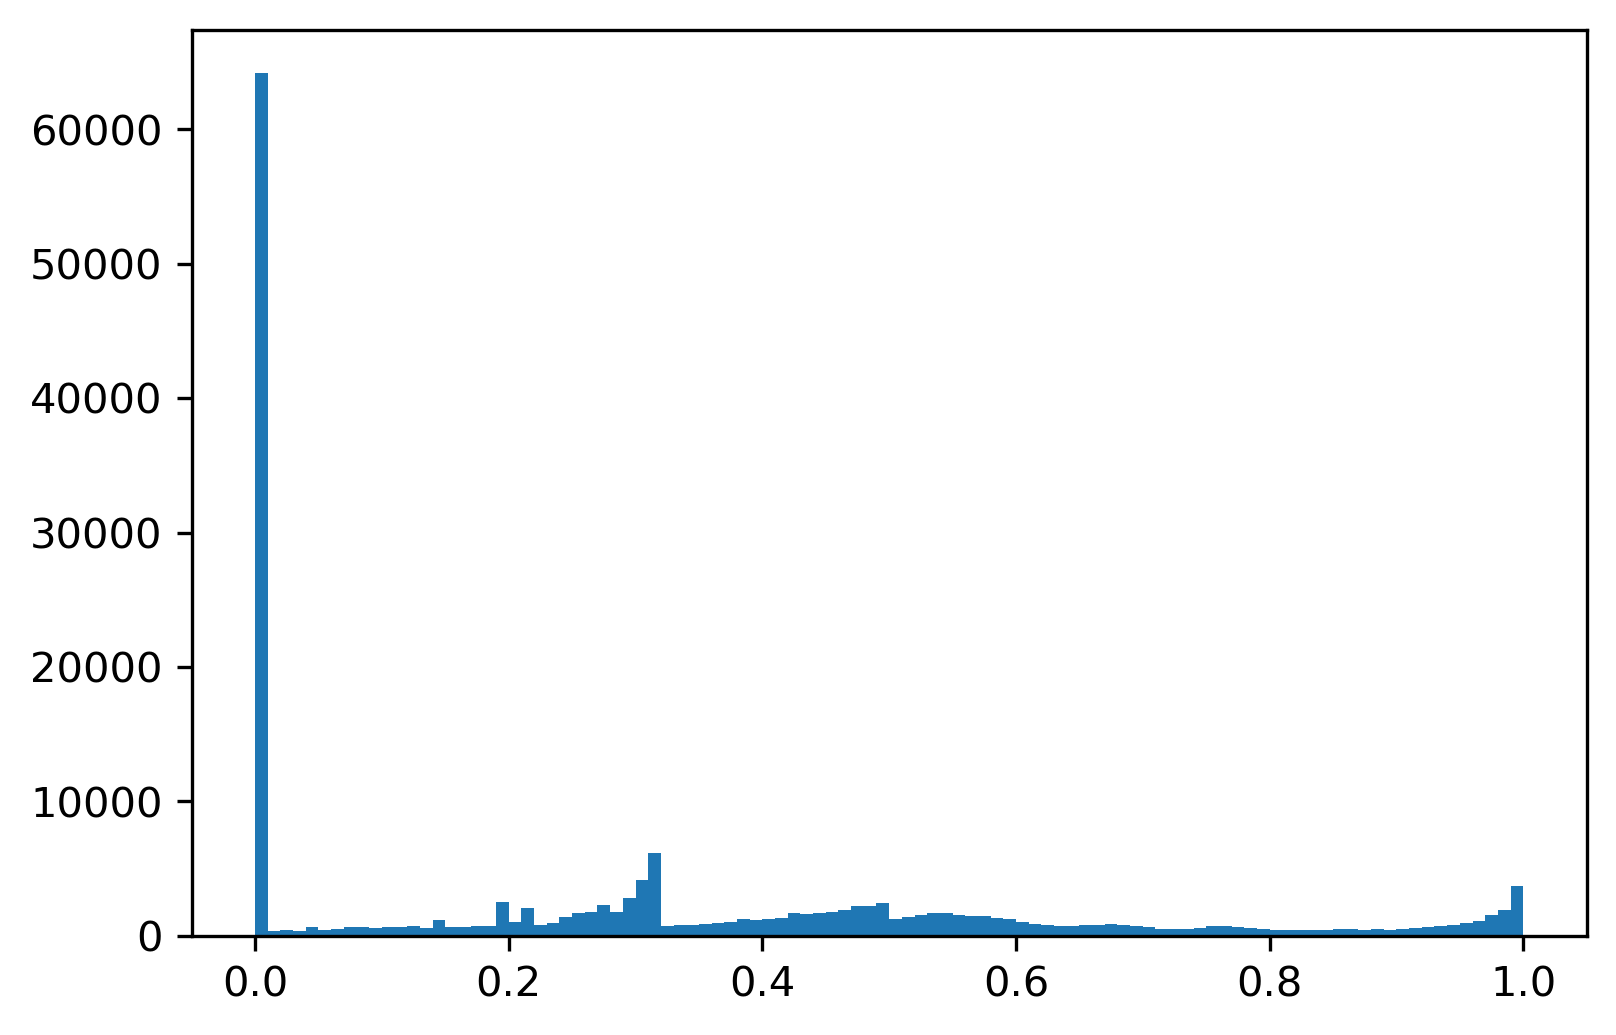

In [80]:
plt.hist(H, bins=100);

(array([3.9341e+04, 4.0100e+02, 5.5200e+02, 6.0000e+02, 6.6700e+02,
        6.4400e+02, 6.7500e+02, 1.0310e+03, 7.0200e+02, 1.9090e+03,
        1.7850e+03, 9.3600e+02, 1.8200e+03, 2.3150e+03, 2.6670e+03,
        6.0540e+03, 6.3000e+02, 6.4900e+02, 7.8600e+02, 9.7900e+02,
        1.0600e+03, 1.4280e+03, 1.5250e+03, 1.9340e+03, 2.0120e+03,
        6.4700e+02, 7.0700e+02, 7.8300e+02, 8.0600e+02, 7.0900e+02,
        5.7500e+02, 4.1100e+02, 4.1800e+02, 4.5000e+02, 3.9600e+02,
        2.9200e+02, 1.9400e+02, 1.8700e+02, 1.8100e+02, 1.0200e+02,
        8.9000e+01, 5.7000e+01, 4.8000e+01, 3.9000e+01, 4.2000e+01,
        2.5000e+01, 2.4000e+01, 4.1000e+01, 6.7000e+01, 1.0600e+02]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

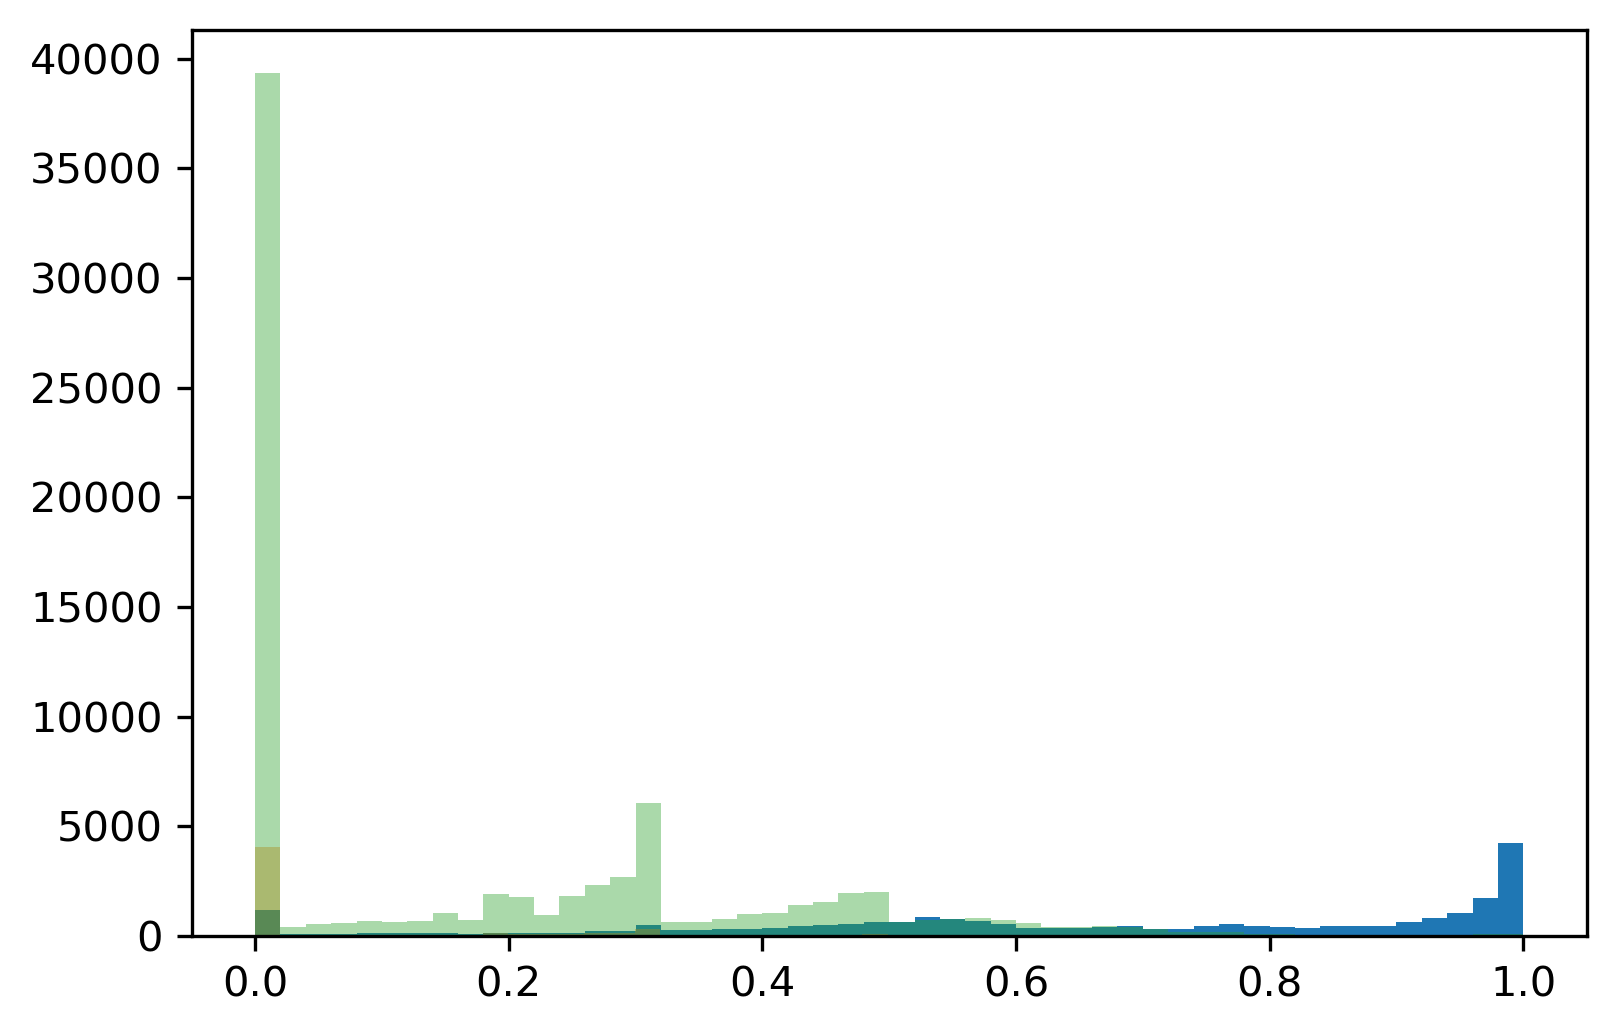

In [81]:
plt.hist(df_nonzeroaf[df_nonzeroaf['INFO_clin_sig']=='benign']['H'], bins=50, density=False)
plt.hist(df_nonzeroaf[df_nonzeroaf['INFO_clin_sig']=='pathogenic']['H'], bins=50, alpha=0.4, density=False)
plt.hist(df_nonzeroaf[df_nonzeroaf['INFO_clin_sig'].str.contains('uncertain-significance')]['H'], bins=50, alpha=0.4, density=True)
# plt.yscale('log')

In [218]:
total_af

array([1.10416870e-01, 8.62392669e-01, 7.11743772e-05, ...,
       6.22225124e-01, 1.37311610e-01, 1.38657472e-01])

In [219]:
H

array([0.93776234, 0.99904521, 0.        , ..., 0.99478981, 0.93400625,
       0.95833596])

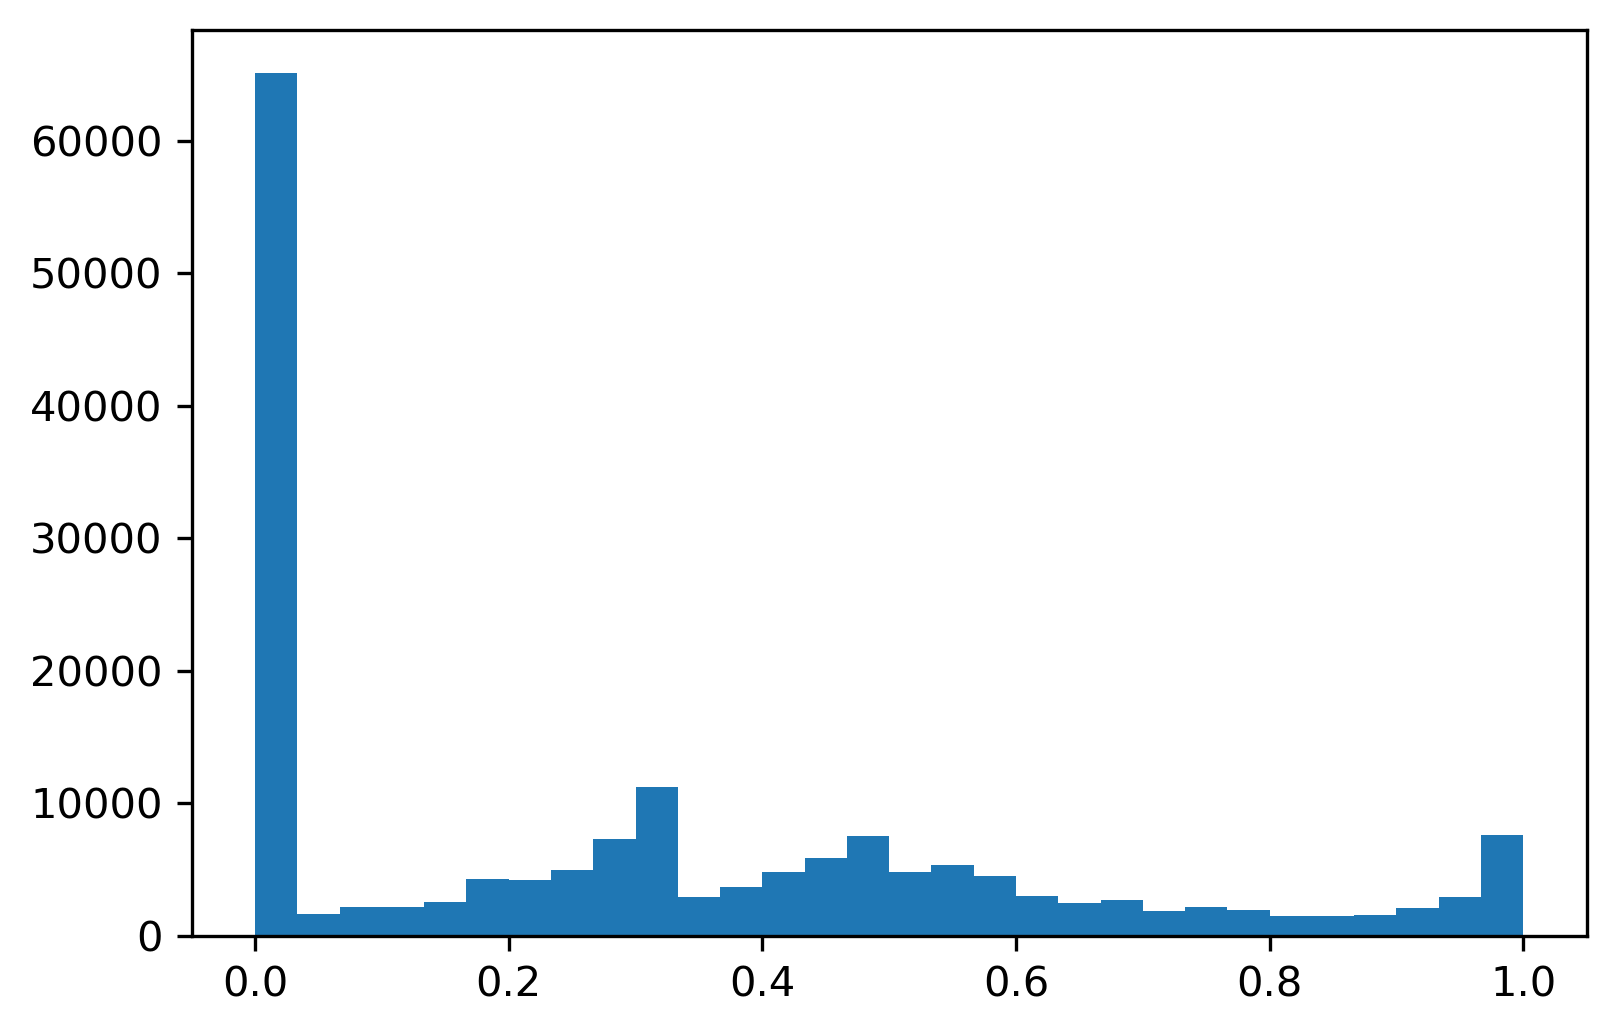

In [211]:
plt.hist(entropy(afs_norm, base=9, axis=1), bins=30);

In [ ]:
df['CHROM'].str.extract('NC_0+(\d{1,2})\.\d{1,2}')[0].value_counts()

2     31736
1     21804
17    17718
11    17404
16    15287
5     14662
3     14109
19    13330
12    13291
9     13286
7     12421
6     11973
10    10767
8      9843
23     9334
15     9134
4      8859
14     8551
13     7258
20     5147
22     5088
18     5001
21     3638
24       69
Name: 0, dtype: int64

In [110]:
df.reset_index(drop=True).memory_usage()

Index                  128
CHROM              2239928
POS                2239928
ID                 2239928
REF                2239928
ALT                2239928
QUAL               2239928
FILTER             2239928
FORMAT             2239928
INFO_clin_sig      2239928
SAMN10492695_AN    2239928
SAMN10492695_AC    2239928
SAMN10492696_AN    2239928
SAMN10492696_AC    2239928
SAMN10492697_AN    2239928
SAMN10492697_AC    2239928
SAMN10492698_AN    2239928
SAMN10492698_AC    2239928
SAMN10492699_AN    2239928
SAMN10492699_AC    2239928
SAMN10492700_AN    2239928
SAMN10492700_AC    2239928
SAMN10492701_AN    2239928
SAMN10492701_AC    2239928
SAMN10492702_AN    2239928
SAMN10492702_AC    2239928
SAMN11605645_AN    2239928
SAMN11605645_AC    2239928
SAMN10492703_AN    2239928
SAMN10492703_AC    2239928
SAMN10492704_AN    2239928
SAMN10492704_AC    2239928
SAMN10492705_AN    2239928
SAMN10492705_AC    2239928
dtype: int64

In [99]:
df[[x+'_AC' for x in pop_fields]].apply(lambda col: col.str.split(',').apply(lambda x: np.sum([int(x_) for x_ in x])), axis='rows')

,SAMN10492695_AC,SAMN10492696_AC,SAMN10492697_AC,SAMN10492698_AC,SAMN10492699_AC,SAMN10492700_AC,SAMN10492701_AC,SAMN10492702_AC,SAMN11605645_AC,SAMN10492703_AC,SAMN10492704_AC,SAMN10492705_AC
ID,,,,,,,,,,,,
rs10000,1624,6,3,275,20,38,1,8,287,281,4,2262
rs1000020884,0,0,0,0,0,0,0,0,0,0,0,0
rs10000250,19241,134,118,3727,150,570,57,79,2841,3861,175,26917
rs1000032847,0,0,0,1,0,0,0,0,0,1,0,1
rs1000035870,2,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
rs999869714,0,0,0,0,0,0,0,0,0,0,0,0
rs999881274,0,0,0,0,0,0,0,0,0,0,0,0
rs999890,42426,45,33,1556,153,303,60,657,2672,1601,93,47905


In [96]:
df[['ALT'] + [x+'_AC' for x in pop_fields]].apply(lambda col: col.str.split(','), axis='rows').explode(['ALT'] + [x+'_AC' for x in pop_fields])

,ALT,SAMN10492695_AC,SAMN10492696_AC,SAMN10492697_AC,SAMN10492698_AC,SAMN10492699_AC,SAMN10492700_AC,SAMN10492701_AC,SAMN10492702_AC,SAMN11605645_AC,SAMN10492703_AC,SAMN10492704_AC,SAMN10492705_AC
ID,,,,,,,,,,,,,
rs10000,G,1624,6,3,275,20,38,1,8,287,281,4,2262
rs1000020884,C,0,0,0,0,0,0,0,0,0,0,0,0
rs10000250,G,19241,134,118,3727,150,570,57,79,2841,3861,175,26917
rs1000032847,C,0,0,0,1,0,0,0,0,0,1,0,1
rs1000035870,A,2,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs999869714,T,0,0,0,0,0,0,0,0,0,0,0,0
rs999881274,G,0,0,0,0,0,0,0,0,0,0,0,0
rs999890,G,42426,45,33,1556,153,303,60,657,2672,1601,93,47905


In [84]:
df.loc['rs1126809']

CHROM                                                   NC_000011.10
POS                                                         89284793
ID                                                         rs1126809
REF                                                                G
ALT                                                                A
QUAL                                                               .
FILTER                                                             .
FORMAT                                                         AN:AC
INFO_clin_sig      association|risk-factor|benign|pathogenic|like...
SAMN10492695_AN                                                71016
SAMN10492695_AC                                                19623
SAMN10492696_AN                                                  124
SAMN10492696_AC                                                    3
SAMN10492697_AN                                                  112
SAMN10492697_AC                   

In [90]:
df['SAMN10492695_AC'].str.split(',').apply(lambda x: np.sum([int(x_) for x_ in x]))

ID
rs10000          1624
rs1000020884        0
rs10000250      19241
rs1000032847        0
rs1000035870        2
                ...  
rs999869714         0
rs999881274         0
rs999890        42426
rs999891        21312
rs999921351         0
Name: SAMN10492695_AC, Length: 279991, dtype: int64

In [71]:
info_cols = ['INFO_clin_sig']

In [73]:
df_ = df.groupby('ID').agg({col: ((lambda x: '|'.join(x)) if col in info_cols else 'first') for col in df.columns})


In [77]:
df_[df_.ID=='rs1126809']['INFO_clin_sig']

ID
rs1126809    association|risk-factor|benign|pathogenic|like...
Name: INFO_clin_sig, dtype: object

In [37]:
x = df.groupby('ID').agg({'INFO': (lambda x: '|'.join(x))})

In [68]:
q = df.groupby('ID').agg({col: 'first' for col in df.columns})

In [70]:
q[q.ID=='rs1126809']['INFO_clin_sig']

ID
rs1126809    association
Name: INFO_clin_sig, dtype: object

In [44]:
x = df[['ID', 'INFO_clin_sig']].groupby('ID').agg({'INFO_clin_sig': (lambda x: '|'.join(x))})

In [61]:
y = df.drop_duplicates('ID').merge(x, left_on='ID', right_index=True, how='right')

In [62]:
y[y.ID=='rs1126809']

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMN10492695,...,SAMN10492702_AC,SAMN11605645_AN,SAMN11605645_AC,SAMN10492703_AN,SAMN10492703_AC,SAMN10492704_AN,SAMN10492704_AC,SAMN10492705_AN,SAMN10492705_AC,INFO_clin_sig_y
190054,NC_000011.10,89284793,rs1126809,G,A,.,.,clin_sig=association,AN:AC,71016:19623,...,4,9838,2250,3688,263,194,1,85982,22292,association|risk-factor|benign|pathogenic|like...


In [58]:
x

,INFO_clin_sig
ID,
rs10000,benign
rs1000020884,uncertain-significance
rs10000250,benign
rs1000032847,uncertain-significance
rs1000035870,likely-benign
...,...
rs999869714,uncertain-significance
rs999881274,likely-benign
rs999890,benign


In [54]:
x.loc['rs1126809']

INFO_clin_sig    association|risk-factor|benign|pathogenic|like...
Name: rs1126809, dtype: object

In [41]:
df.ID.value_counts()

rs1126809      9
rs1801133      7
rs17158558     7
rs75820036     7
rs77724903     7
              ..
rs1887415      1
rs146424575    1
rs41288979     1
rs780820310    1
rs11388353     1
Name: ID, Length: 279991, dtype: int64

In [26]:
df['SAMN10492695_AC'].str.split(',').apply(lambda x: np.sum([int(x_) for x_ in x]))

0            10
1            27
2           264
3         57069
4             0
          ...  
333716       67
333717     6549
333718     6549
333719        0
333720     9183
Name: SAMN10492695_AC, Length: 333721, dtype: int64

In [8]:
pop_fields = df.columns[ df.columns.str.contains('SAMN')].tolist()

In [12]:
df[pop_fields].apply(lambda col: col.str.split(':', expand=True), axis='rows')

ValueError: If using all scalar values, you must pass an index